In [0]:
import os
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, approx_count_distinct, avg, max, min, row_number
from pyspark.sql.window import Window

# Environment variables for Azure Data Lake Storage
storage_account_name = os.getenv("STORAGE_ACCOUNT_NAME")
storage_container_name = os.getenv("STORAGE_CONTAINER_NAME")
tf_var_client_id = os.getenv("TF_VAR_CLIENT_ID")
tf_var_client_secret = os.getenv("TF_VAR_CLIENT_SECRET")
tf_var_tenant_id = os.getenv("TF_VAR_TENANT_ID")

if not all(
    [
        storage_account_name,
        storage_container_name,
        tf_var_client_id,
        tf_var_client_secret,
        tf_var_tenant_id,
    ]
):
    raise ValueError("One or more environment variables are missing")

spark = SparkSession.builder.appName("MyApp").getOrCreate()

spark.conf.set(
    f"fs.azure.account.auth.type.{storage_account_name}.dfs.core.windows.net",
    "OAuth",
)
spark.conf.set(
    f"fs.azure.account.oauth.provider.type.{storage_account_name}.dfs.core.windows.net",
    "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
)
spark.conf.set(
    f"fs.azure.account.oauth2.client.id.{storage_account_name}.dfs.core.windows.net",
    tf_var_client_id,
)
spark.conf.set(
    f"fs.azure.account.oauth2.client.secret.{storage_account_name}.dfs.core.windows.net",
    tf_var_client_secret,
)
spark.conf.set(
    f"fs.azure.account.oauth2.client.endpoint.{storage_account_name}.dfs.core.windows.net",
    f"https://login.microsoftonline.com/{tf_var_tenant_id}/oauth2/token",
)

# Load Parquet files from ADLS
incremental_hotel_weather_path = f"abfss://{storage_container_name}@{storage_account_name}.dfs.core.windows.net/incremental-hotel-weather"
df = spark.read.format("parquet").parquet(incremental_hotel_weather_path)

# Show the loaded DataFrame
df.show(truncate=False)

+-----------------------------------------------+----------+----------+--------------+-------+-------+-------------+---------+-----------+----------------------+----------+-------------------+----+-----+---+
|address                                        |avg_tmpr_c|avg_tmpr_f|city          |country|geoHash|id           |latitude |longitude  |name                  |wthr_date |processed_date     |year|month|day|
+-----------------------------------------------+----------+----------+--------------+-------+-------+-------------+---------+-----------+----------------------+----------+-------------------+----+-----+---+
|Homewood Suites - Mall of America              |15.9      |60.7      |Minneapolis   |US     |9zvx   |1202590842885|44.85201 |-93.23993  |2261 Killebrew Dr     |2016-10-01|2016-09-30 22:00:00|2016|10   |1  |
|Little Belt Inn Neihart                        |10.8      |51.5      |Neihart       |US     |c837   |1571958030336|46.933598|-110.735886|316 N Main St         |2016-10

In [0]:
df_stream = (
    spark.readStream.format("cloudFiles")
    .option("cloudFiles.format", "parquet")
    .schema(df.schema)
    .load(incremental_hotel_weather_path)
)

result_df = df_stream.groupBy("city", "wthr_date").agg(
    F.approx_count_distinct("id").alias("distinct_hotels"),
    F.avg("avg_tmpr_c").alias("avg_temperature"),
    F.max("avg_tmpr_c").alias("max_temperature"),
    F.min("avg_tmpr_c").alias("min_temperature"),
)

result_df.explain(extended=True)

== Parsed Logical Plan ==
'Aggregate ['city, 'wthr_date], ['city, 'wthr_date, approx_count_distinct('id, 0.05, 0, 0) AS distinct_hotels#338174, avg('avg_tmpr_c) AS avg_temperature#338176, max('avg_tmpr_c) AS max_temperature#338178, min('avg_tmpr_c) AS min_temperature#338180]
+- StreamingRelation DataSource(org.apache.spark.sql.SparkSession@386582d8,cloudFiles,List(),Some(StructType(StructField(address,StringType,true),StructField(avg_tmpr_c,DoubleType,true),StructField(avg_tmpr_f,DoubleType,true),StructField(city,StringType,true),StructField(country,StringType,true),StructField(geoHash,StringType,true),StructField(id,StringType,true),StructField(latitude,DoubleType,true),StructField(longitude,DoubleType,true),StructField(name,StringType,true),StructField(wthr_date,StringType,true),StructField(processed_date,TimestampType,true),StructField(year,IntegerType,true),StructField(month,IntegerType,true),StructField(day,IntegerType,true))),List(),None,Map(cloudFiles.format -> parquet, path -> 

In [0]:
query = (
    result_df.writeStream.outputMode("complete")
    .format("memory")
    .queryName("result_df_query")
    .start()
)

In [0]:
top10 = spark.sql("""
    SELECT city, wthr_date, distinct_hotels, avg_temperature, max_temperature, min_temperature
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY city ORDER BY distinct_hotels DESC, wthr_date DESC) as row_num
        FROM result_df_query
    ) ranked
    WHERE row_num = 1
    ORDER BY distinct_hotels DESC
    LIMIT 10
""")

# Show the resulting DataFrame
top10.show(truncate=False)

+----------+----------+---------------+------------------+---------------+---------------+
|city      |wthr_date |distinct_hotels|avg_temperature   |max_temperature|min_temperature|
+----------+----------+---------------+------------------+---------------+---------------+
|Paris     |2017-09-29|444            |18.043929359823526|18.3           |17.8           |
|London    |2017-09-23|250            |14.199999999999946|14.2           |14.2           |
|Barcelona |2016-10-28|211            |17.098086124401853|17.1           |16.7           |
|Milan     |2017-09-20|165            |14.35465838509315 |15.4           |14.3           |
|Amsterdam |2017-08-31|85             |14.400000000000002|14.4           |14.4           |
|Paddington|2017-09-23|19             |14.199999999999994|14.2           |14.2           |
|New York  |2017-08-11|6              |23.3              |23.3           |23.3           |
|San Diego |2017-09-20|6              |20.2              |20.2           |20.2           |

In [0]:
agg_df = spark.sql("""
    SELECT * FROM result_df_query ORDER BY distinct_hotels DESC
""")

# Show the resulting DataFrame
agg_df.show(truncate=False)

+---------+----------+---------------+------------------+---------------+---------------+
|city     |wthr_date |distinct_hotels|avg_temperature   |max_temperature|min_temperature|
+---------+----------+---------------+------------------+---------------+---------------+
|Paris    |2017-08-18|444            |17.89999999999985 |17.9           |17.9           |
|London   |2016-10-16|250            |12.099999999999946|12.1           |12.1           |
|London   |2017-08-25|250            |17.09999999999994 |17.1           |17.1           |
|London   |2017-09-19|250            |10.5              |10.5           |10.5           |
|London   |2016-10-10|250            |8.400000000000038 |8.4            |8.4            |
|London   |2017-09-23|250            |14.199999999999946|14.2           |14.2           |
|London   |2017-09-03|250            |13.900000000000059|13.9           |13.9           |
|London   |2017-08-07|250            |15.59999999999994 |15.6           |15.6           |
|Paris    

In [0]:
# Get the list of top 10 city names
top10_cities = [row['city'] for row in top10.select("city").distinct().collect()]

# Filter agg_df using only names that are present in top10
filtered_agg_df = agg_df.filter(agg_df.city.isin(top10_cities))

# Show top10_cities
top10_cities

Out[21]: ['Paris',
 'London',
 'Barcelona',
 'Milan',
 'Amsterdam',
 'Paddington',
 'New York',
 'San Diego',
 'Houston',
 'Memphis']

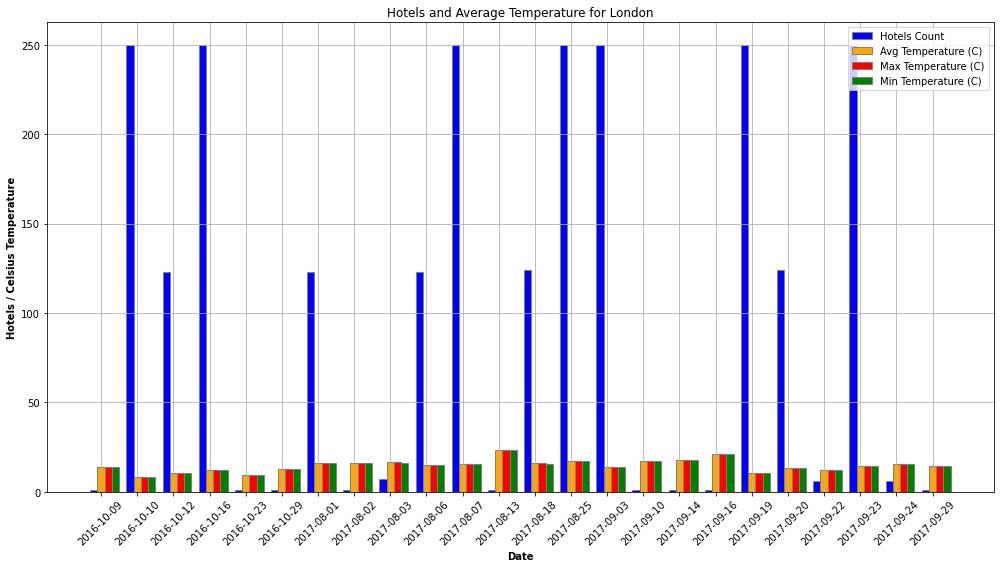

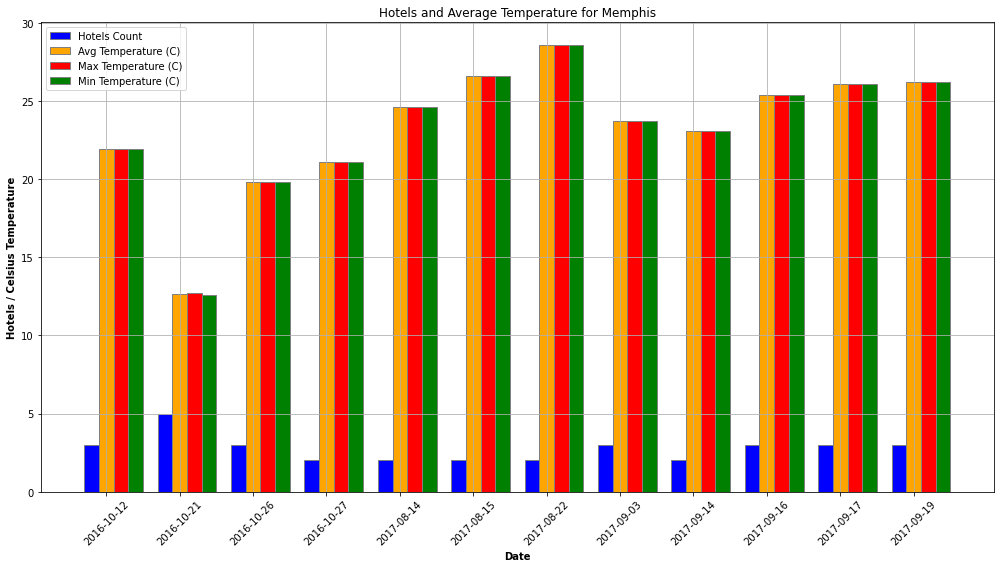

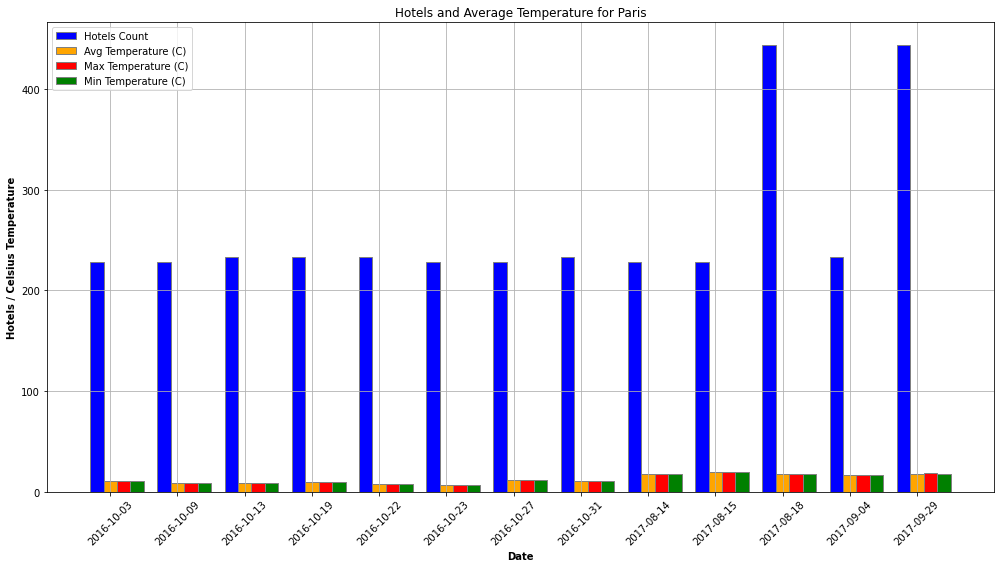

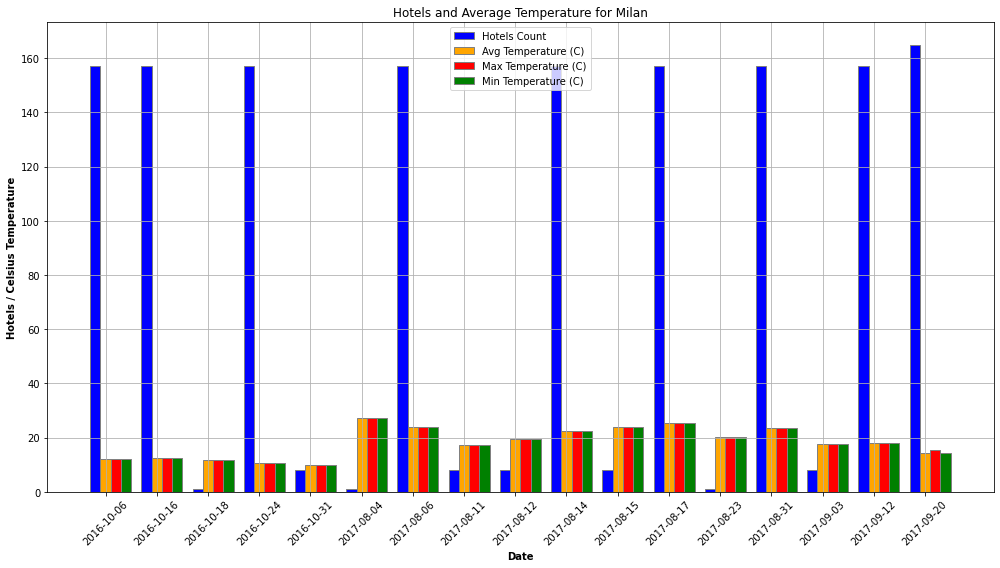

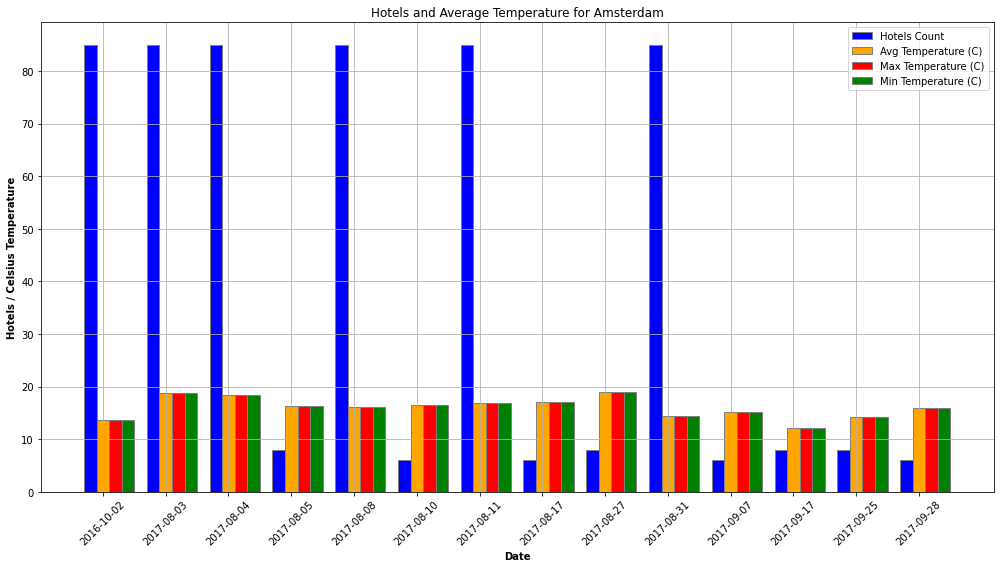

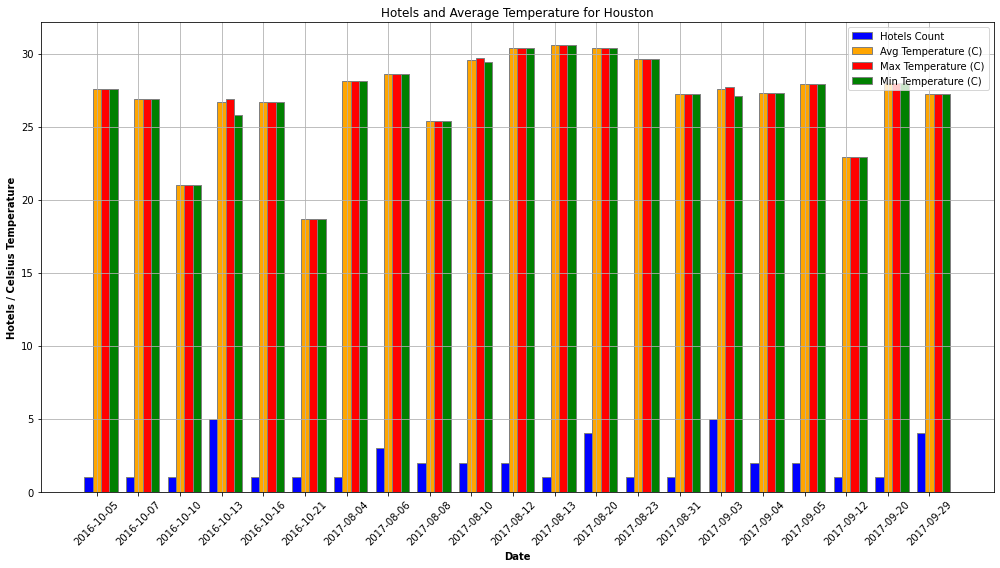

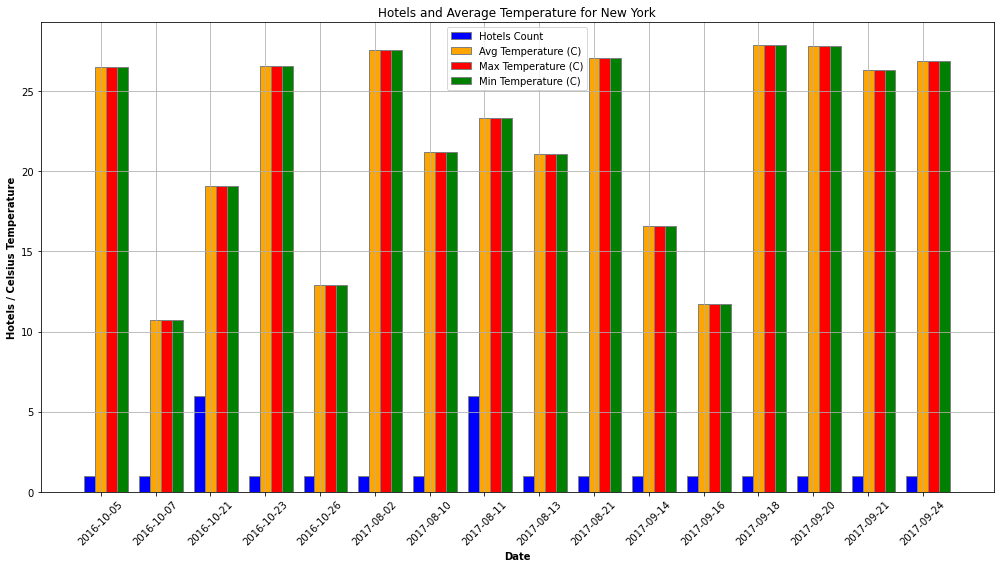

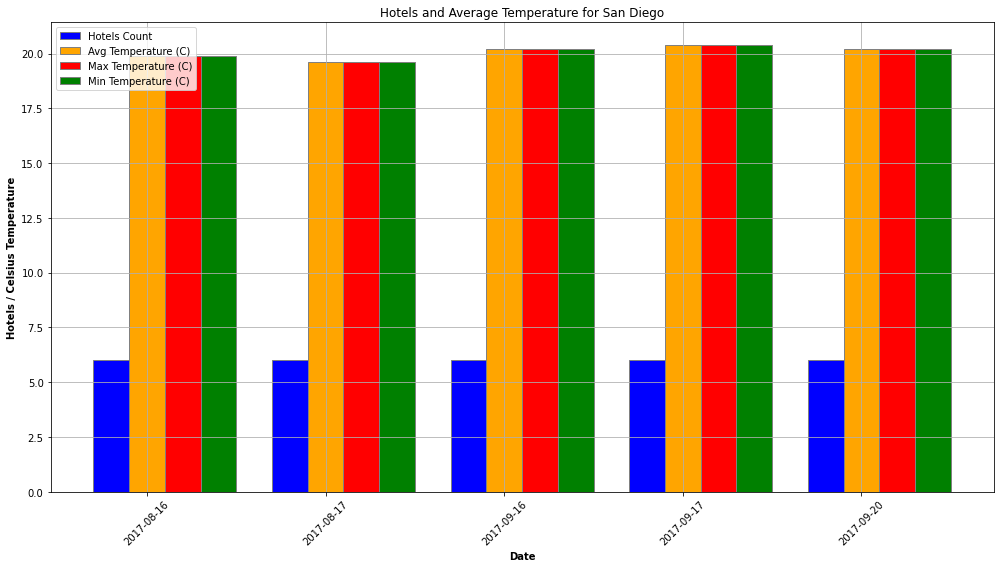

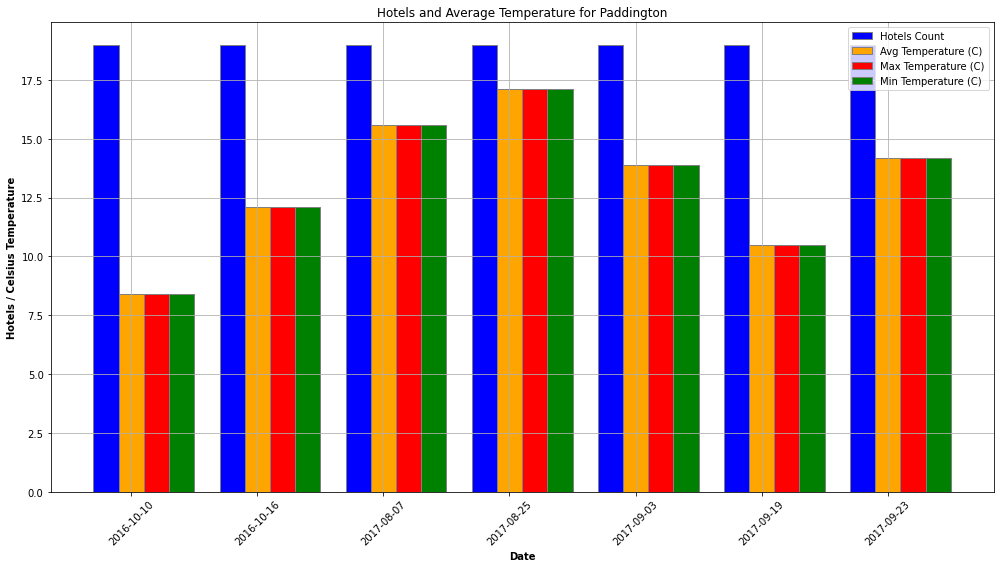

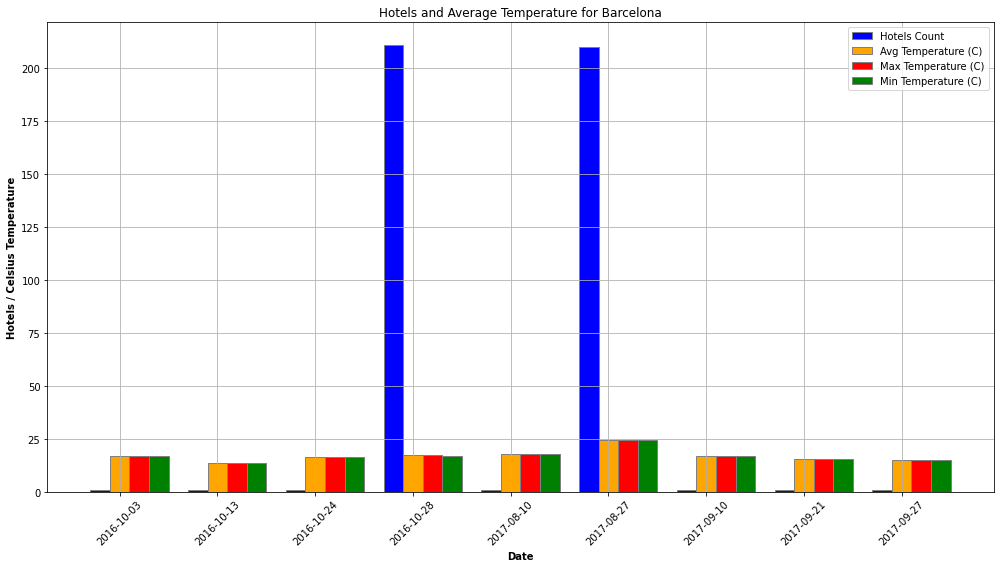

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import DataFrame

def plot_city_data(city_name: str, city_df: DataFrame) -> None:
    # Convert the Spark DataFrame to a Pandas DataFrame
    pdf = city_df.toPandas()
    
    # Ensure the dates are sorted and format the dates to show only the date part
    pdf = pdf.sort_values('wthr_date')
    pdf['wthr_date'] = pd.to_datetime(pdf['wthr_date']).dt.strftime('%Y-%m-%d')
    
    # Set the figure size
    plt.figure(figsize=(14, 8))
    
    # Width for bars
    bar_width = 0.2
    dates = pdf['wthr_date']
    
    # Bar positions
    r1 = range(len(pdf))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    
    # Plot the distinct hotels as bars
    plt.bar(r1, pdf['distinct_hotels'], color='blue', width=bar_width, edgecolor='grey', label='Hotels Count')
    
    # Plot the temperatures as bars
    plt.bar(r2, pdf['avg_temperature'], color='orange', width=bar_width, edgecolor='grey', label='Avg Temperature (C)')
    plt.bar(r3, pdf['max_temperature'], color='red', width=bar_width, edgecolor='grey', label='Max Temperature (C)')
    plt.bar(r4, pdf['min_temperature'], color='green', width=bar_width, edgecolor='grey', label='Min Temperature (C)')
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Date', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(pdf))], dates, rotation=45)
    
    # Set plot title and labels
    plt.title(f'Hotels and Average Temperature for {city_name}')
    plt.ylabel('Hotels / Celsius Temperature', fontweight='bold')
    
    # Show legend
    plt.legend()
    
    # Show grid
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Get the list of unique cities in the filtered DataFrame
unique_cities = [row['city'] for row in filtered_agg_df.select("city").distinct().collect()]

# Plot the data for each city
for city_name in unique_cities:
    city_df = filtered_agg_df.filter(filtered_agg_df.city == city_name)
    plot_city_data(city_name, city_df)